In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [10]:
from shapely.geometry import Point
from shapely.geometry import Polygon
import pyproj
from shapely.ops import transform
from functools import partial

In [55]:
file_path = 'D:/Downloads/shp_bdry_counties_in_minnesota/mn_county_boundaries.shp'
counties = gpd.read_file(file_path)
counties = counties.to_crs(epsg=32615)
counties = counties.dissolve(by='CTY_NAME', as_index=False)

In [195]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Wilmar", "coords": (-95.0487, 45.1224), "radius": circle_radius},
    {"name": "Fergus falls", "coords": (-96.0778, 46.2835), "radius": circle_radius},
    {"name": "Duluth", "coords": (-92.1005, 46.7867), "radius": circle_radius},
    {"name": "Owatonna", "coords": (-93.2260, 44.0879), "radius": circle_radius},
    {"name": "Rochester", "coords": (-92.4802, 44.0121), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

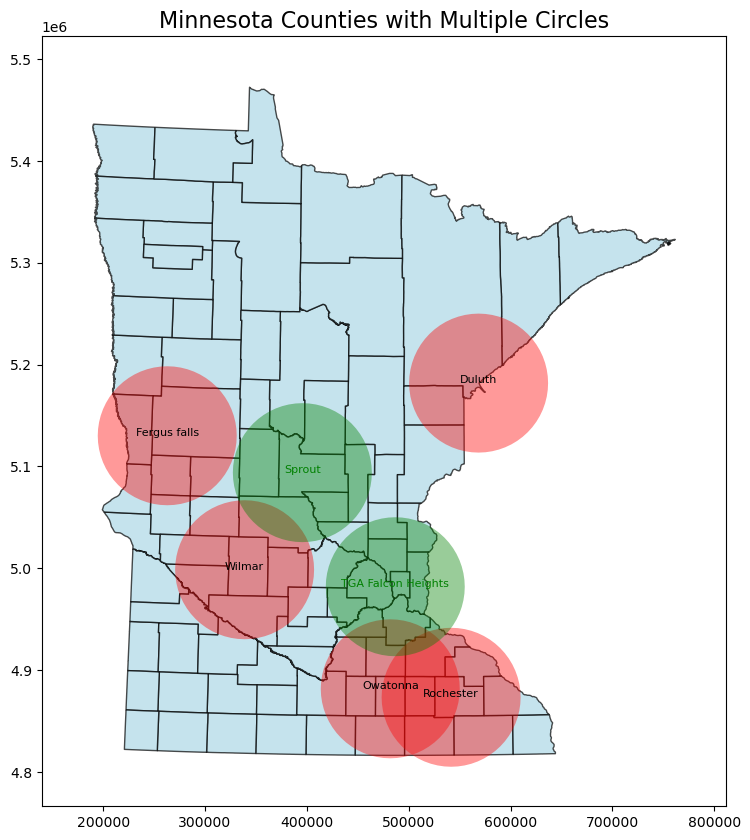

In [196]:
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, legend=True)    # Plot circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)


ax.set_title("Minnesota Counties with Multiple Circles", fontsize=16)
plt.show()


In [120]:
counties[counties['CTY_NAME'] == 'Lake']

,CTY_NAME,geometry,AREA,PERIMETER,CTYONLY_,CTYONLY_ID,COUN,CTY_ABBR,CTY_FIPS,Shape_Leng,Shape_Area,intersection_area,county_area,proportion_covered
37,Lake,"MULTIPOLYGON (((633138.607 5239646.118, 633138...",5.924885e+09,433067.747079,12.0,11.0,38,LAKE,75,433067.746416,5.924885e+09,1.608031e+09,5.924950e+09,0.2714


In [121]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties

,CTY_NAME,proportion_covered
73,Steele,1.000000
25,Grant,1.000000
65,Rice,1.000000
78,Wabasha,1.000000
54,Olmsted,1.000000
19,Dodge,1.000000
46,Meeker,1.000000
80,Waseca,1.000000
83,Wilkin,1.000000
33,Kandiyohi,1.000000


In [122]:
covered_counties.to_csv('counties_ratios.csv', index=False)

How much is the distance between current suppliers and warehouse
Once you decide the radius, can you give me ratios of surrounding counties for each of the 5 target counties?
give the number of current suppliers (from the map) in that same circle for each of the target counties?

In [123]:
map_data = pd.read_excel('D:/Carlson coursework/Sem 1/Live case/Data files/MN Food Hub - Combined.xlsx', sheet_name='MN Food Hub Map 2024- Brick and')

In [124]:
map_data.head()

,Name,Type of Location,Latitude,Longitude
0,The Good Acre,Warehouse,44.990372,-93.167149
1,Sprout MN - Growers & Makers Marketplace,Warehouse,45.990932,-94.348274
2,Reads Landing Brewery,Buyers,44.402734,-92.078834
3,Harbor View Cafe,Buyers,44.438811,-92.146751
4,Herb + Arrow,Buyers,44.384662,-92.033384


In [125]:
warehouses = map_data[map_data['Type of Location'] == 'Warehouse']
warehouses

,Name,Type of Location,Latitude,Longitude
0,The Good Acre,Warehouse,44.990372,-93.167149
1,Sprout MN - Growers & Makers Marketplace,Warehouse,45.990932,-94.348274


In [126]:
suppliers = map_data[map_data['Type of Location'] == 'Suppliers']
suppliers

,Name,Type of Location,Latitude,Longitude
78,AlliCat Farm,Suppliers,46.401998,-93.738291
79,Ardent Acres Farm Grass-fed Beef,Suppliers,46.667228,-93.532215
80,Buck Hills Farm,Suppliers,46.537224,-93.537320
81,Clear Lake Gardens,Suppliers,46.435481,-93.496668
82,D & L Family Farm,Suppliers,46.277829,-93.448465
...,...,...,...,...
352,Hlee Lee¬†,Suppliers,44.633194,-93.066272
353,Fox Valley Farms,Suppliers,44.461808,-92.012845
354,Don Buck Farm,Suppliers,44.304286,-92.605032
355,Willmar,Suppliers,45.122371,-95.048659


In [127]:
# Request URL
url = "http://localhost:8080/ors/v2/directions/driving-car"

for i, row in suppliers.iterrows():
    params = {
        "start": f"{row['Longitude']},{row['Latitude']}",
        "end": "-93.167149,44.990372"
    }
    response = requests.get(url, params=params)
    distance_1 = 1000000000
    distance_2 = 1000000000

    if response.status_code == 200:
        data = response.json()
        distance_1 = data["features"][0]["properties"]["segments"][0]["distance"]
        # print(f"Distance: {distance} meters")
    else:
        print(response.status_code)
        print('hi',params)
        print(f"Error: {response.status_code}, {response.text}")

    params = {
        "start": f"{row['Longitude']},{row['Latitude']}",
        "end": "-94.348274,45.990932"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        distance_2 = data["features"][0]["properties"]["segments"][0]["distance"]
        # print(f"Distance: {distance} meters")
    else:

        print(f"Error: {response.status_code}, {response.text}")

    distance = min(distance_1, distance_2)
    suppliers.loc[i, 'distance_to_closest_hub'] = distance

suppliers


# params = {
#     "start": "-93.738291,46.401998",
#      'start': '46.4019981,-93.7382913'
#     "end": "-93.167149,44.990372"
# }
# # Make the API request
# response = requests.get(url, params=params)

# # Check if the request was successful
# if response.status_code == 200:
#     # Parse the JSON response
#     data = response.json()
    
#     # Extract the distance from the segments
#     distance = data["features"][0]["properties"]["segments"][0]["distance"]
#     print(f"Distance: {distance} meters")
# else:
#     print(f"Error: {response.status_code}, {response.text}")




C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\68787492.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suppliers.loc[i, 'distance_to_closest_hub'] = distance


404
hi {'start': '-92.3384726,45.0150905', 'end': '-93.167149,44.990372'}
Error: 404, {"error":{"code":2010,"message":"Could not find routable point within a radius of 200000.0 meters of specified coordinate 0: -92.3384726 45.0150905."},"info":{"engine":{"build_date":"2024-10-09T09:23:42Z","version":"8.2.0"},"timestamp":1732781523608}}
Error: 404, {"error":{"code":2010,"message":"Could not find routable point within a radius of 200000.0 meters of specified coordinate 0: -92.3384726 45.0150905."},"info":{"engine":{"build_date":"2024-10-09T09:23:42Z","version":"8.2.0"},"timestamp":1732781523624}}
404
hi {'start': '-92.4599451999999,44.6966415', 'end': '-93.167149,44.990372'}
Error: 404, {"error":{"code":2010,"message":"Could not find routable point within a radius of 200000.0 meters of specified coordinate 0: -92.4599452 44.6966415."},"info":{"engine":{"build_date":"2024-10-09T09:23:42Z","version":"8.2.0"},"timestamp":1732781523966}}
Error: 404, {"error":{"code":2010,"message":"Could not

,Name,Type of Location,Latitude,Longitude,distance_to_closest_hub
78,AlliCat Farm,Suppliers,46.401998,-93.738291,9.775110e+04
79,Ardent Acres Farm Grass-fed Beef,Suppliers,46.667228,-93.532215,1.306064e+05
80,Buck Hills Farm,Suppliers,46.537224,-93.537320,1.122299e+05
81,Clear Lake Gardens,Suppliers,46.435481,-93.496668,1.194823e+05
82,D & L Family Farm,Suppliers,46.277829,-93.448465,1.204598e+05
...,...,...,...,...,...
352,Hlee Lee¬†,Suppliers,44.633194,-93.066272,5.546830e+04
353,Fox Valley Farms,Suppliers,44.461808,-92.012845,1.000000e+09
354,Don Buck Farm,Suppliers,44.304286,-92.605032,1.041971e+05
355,Willmar,Suppliers,45.122371,-95.048659,1.517365e+05


In [128]:
suppliers[suppliers['distance_to_closest_hub'] == 1000000000]['distance_to_closest_hub'] = 90000.0
# suppliers = suppliers[suppliers['distance_to_closest_hub'] != 1000000000]
print(suppliers['distance_to_closest_hub'].mean())
print(suppliers['distance_to_closest_hub'].median())

suppliers

121956911.20430107
88139.2


C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2237814491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suppliers[suppliers['distance_to_closest_hub'] == 1000000000]['distance_to_closest_hub'] = 90000.0


,Name,Type of Location,Latitude,Longitude,distance_to_closest_hub
78,AlliCat Farm,Suppliers,46.401998,-93.738291,9.775110e+04
79,Ardent Acres Farm Grass-fed Beef,Suppliers,46.667228,-93.532215,1.306064e+05
80,Buck Hills Farm,Suppliers,46.537224,-93.537320,1.122299e+05
81,Clear Lake Gardens,Suppliers,46.435481,-93.496668,1.194823e+05
82,D & L Family Farm,Suppliers,46.277829,-93.448465,1.204598e+05
...,...,...,...,...,...
352,Hlee Lee¬†,Suppliers,44.633194,-93.066272,5.546830e+04
353,Fox Valley Farms,Suppliers,44.461808,-92.012845,1.000000e+09
354,Don Buck Farm,Suppliers,44.304286,-92.605032,1.041971e+05
355,Willmar,Suppliers,45.122371,-95.048659,1.517365e+05


C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\3849153961.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


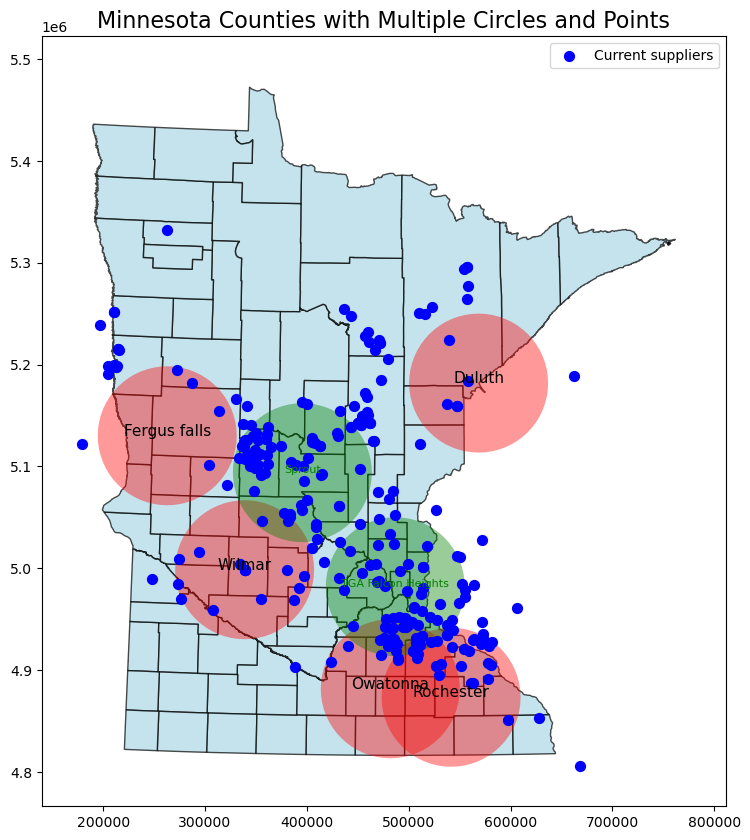

In [202]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Current suppliers')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=11, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [198]:
# Find the circles for Owatonna and Rochester
owatonna_circle = circles[circles['name'] == 'Owatonna'].iloc[0].geometry
rochester_circle = circles[circles['name'] == 'Rochester'].iloc[0].geometry

# Calculate the intersection of the two circles
intersection = owatonna_circle.intersection(rochester_circle)

# Calculate the areas
owatonna_area = owatonna_circle.area
rochester_area = rochester_circle.area
intersection_area = intersection.area

# Calculate the union area
union_area = owatonna_area + rochester_area - intersection_area

# Calculate overlap percentage (relative to the union)
overlap_percentage_union = (intersection_area / union_area) * 100

# Optional: Overlap percentage relative to Owatonna
overlap_percentage_owatonna = (intersection_area / owatonna_area) * 100

# Optional: Overlap percentage relative to Rochester
overlap_percentage_rochester = (intersection_area / rochester_area) * 100

# Print the results
print(f"Overlap Percentage (relative to union): {overlap_percentage_union:.2f}%")
print(f"Overlap Percentage (relative to Owatonna): {overlap_percentage_owatonna:.2f}%")
print(f"Overlap Percentage (relative to Rochester): {overlap_percentage_rochester:.2f}%")

Overlap Percentage (relative to union): 29.50%
Overlap Percentage (relative to Owatonna): 45.56%
Overlap Percentage (relative to Rochester): 45.56%


In [130]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
print(points_in_circles.count())
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

Name                       100
Type of Location           100
Latitude                   100
Longitude                  100
distance_to_closest_hub    100
geometry                   100
index_right                100
name                       100
dtype: int64


name
Duluth           5
Fergus falls     4
Owatonna        36
Rochester       37
Wilmar          18
Name: Name, dtype: int64

In [178]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Wilmar", "coords": (-95.0487, 45.1224), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


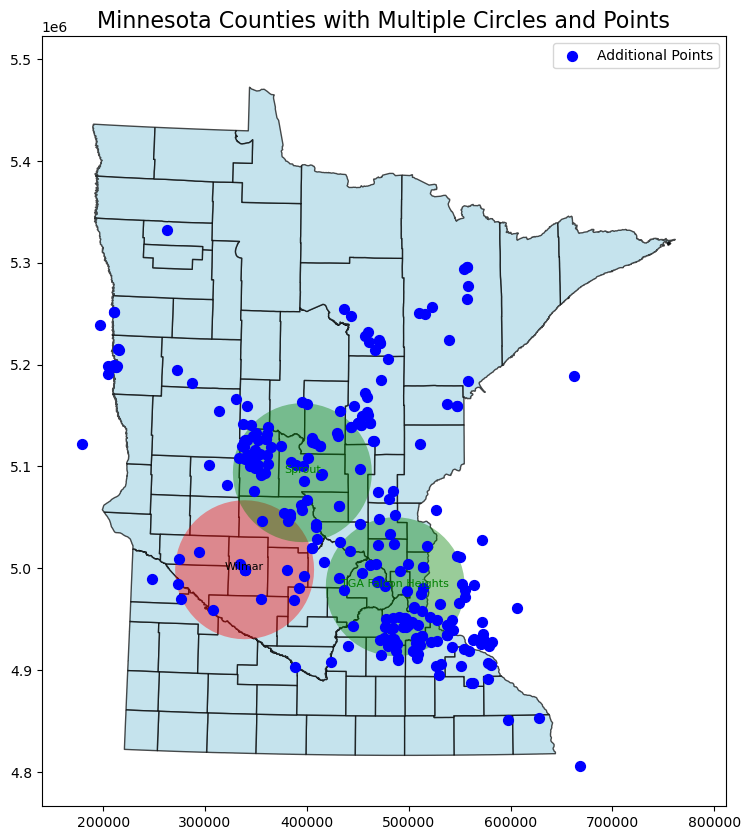

In [179]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [182]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties
# covered_counties.to_csv('counties_ratios_Wilmar.csv', index=False)

,CTY_NAME,proportion_covered
33,Kandiyohi,1.000000
46,Meeker,1.000000
11,Chippewa,0.960753
64,Renville,0.927813
75,Swift,0.730931
60,Pope,0.682762
72,Stearns,0.613619
45,McLeod,0.400985
86,Yellow Medicine,0.342586
63,Redwood,0.148246


In [145]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

name
Wilmar    18
Name: Name, dtype: int64

In [183]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Fergus falls", "coords": (-96.0778, 46.2835), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


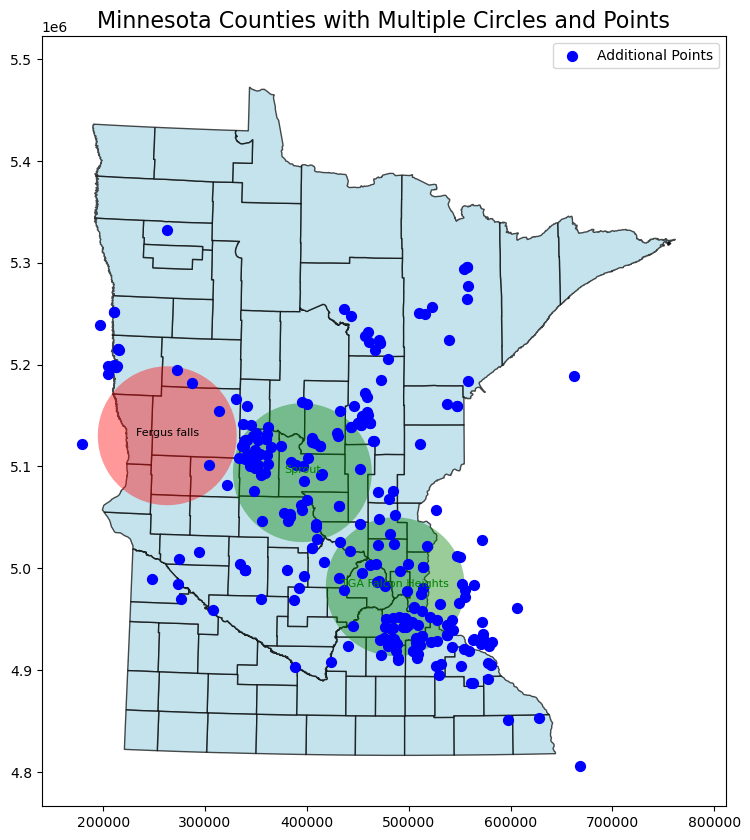

In [184]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [185]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties.to_csv('counties_ratios_Fergus_falls.csv', index=False)
covered_counties

,CTY_NAME,proportion_covered
25,Grant,1.000000
83,Wilkin,1.000000
55,Otter Tail,0.910637
20,Douglas,0.623556
77,Traverse,0.542955
13,Clay,0.345542
74,Stevens,0.227666
2,Becker,0.216671
60,Pope,0.016580


In [149]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

name
Fergus falls    4
Name: Name, dtype: int64

In [186]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Duluth", "coords": (-92.1005, 46.7867), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


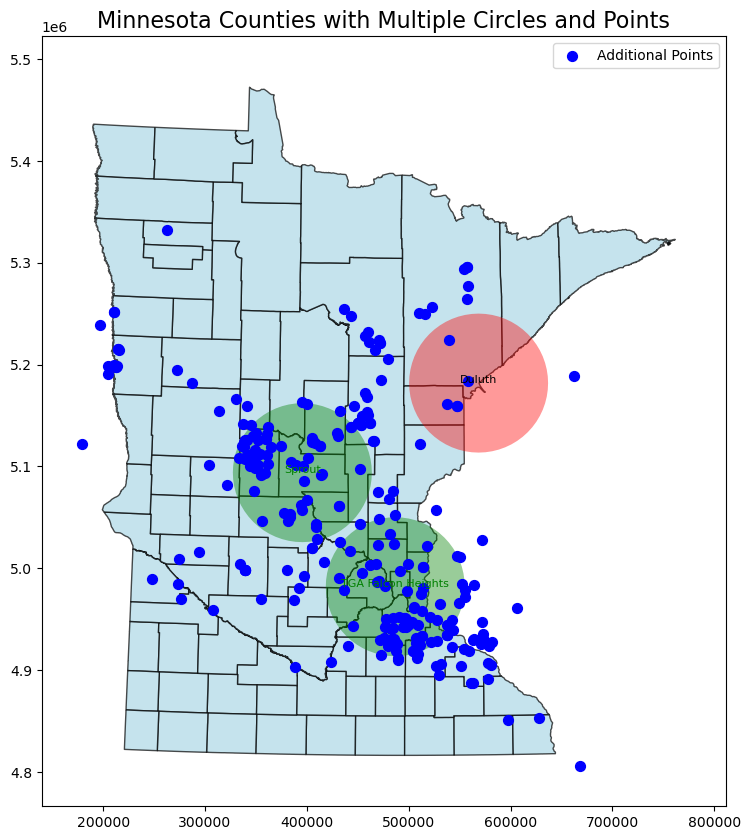

In [187]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [188]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties.to_csv('counties_ratios_Duluth.csv', index=False)
covered_counties

,CTY_NAME,proportion_covered
8,Carlton,0.833889
71,St. Louis,0.303004
57,Pine,0.173770
37,Lake,0.124023


In [152]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

name
Duluth    5
Name: Name, dtype: int64

In [189]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Owatonna", "coords": (-93.2260, 44.0879), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


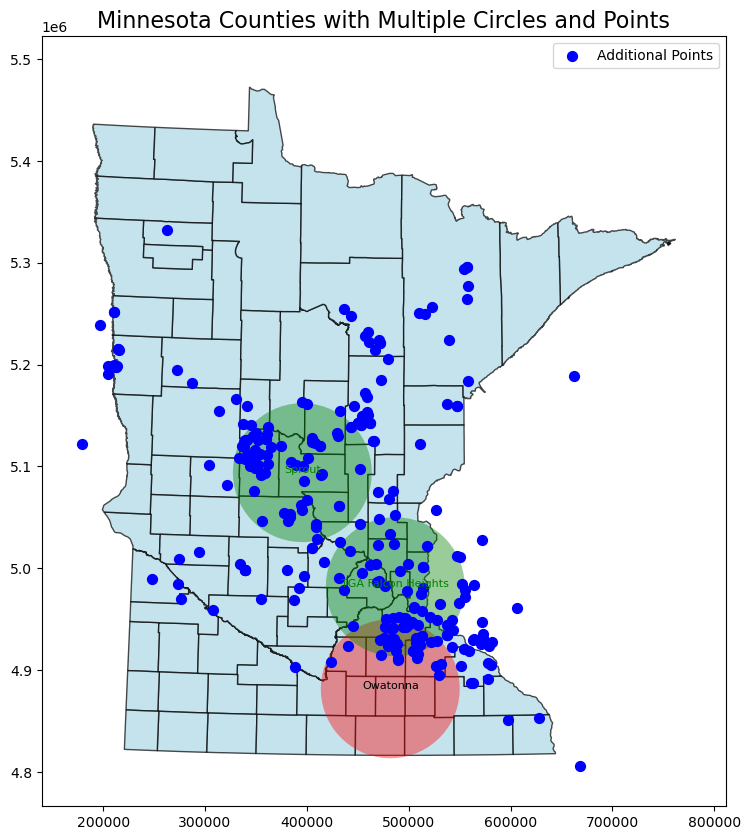

In [190]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [191]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties.to_csv('counties_ratios_Owatonna.csv', index=False)
covered_counties

,CTY_NAME,proportion_covered
19,Dodge,1.000000
65,Rice,1.000000
73,Steele,1.000000
80,Waseca,1.000000
23,Freeborn,0.978367
39,Le Sueur,0.971115
24,Goodhue,0.756004
49,Mower,0.690576
54,Olmsted,0.540324
18,Dakota,0.514859


In [161]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

name
Owatonna    36
Name: Name, dtype: int64

In [192]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Rochester", "coords": (-92.4802, 44.0121), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


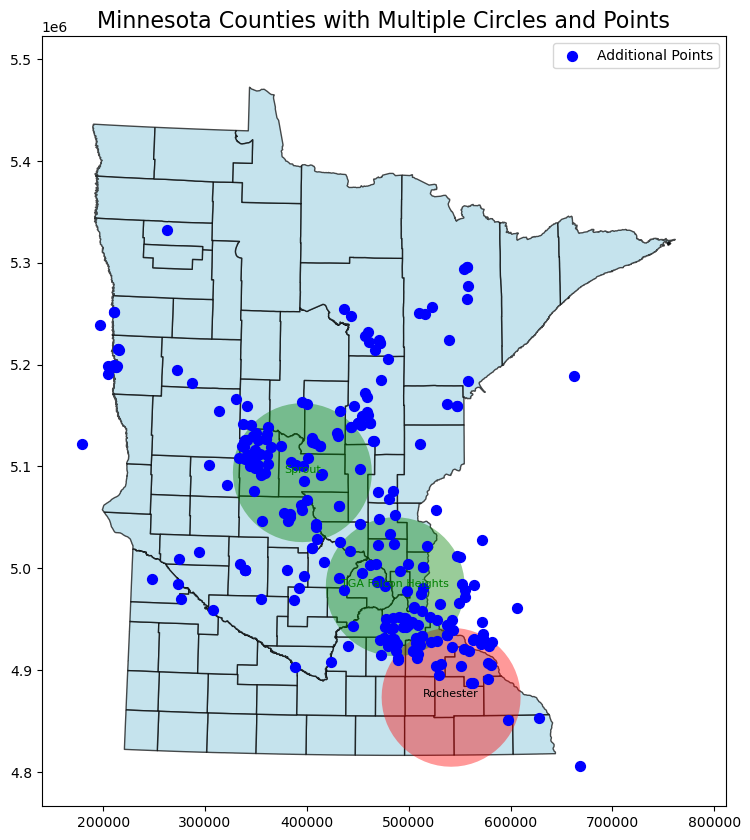

In [193]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [194]:
# Step 1: Create a union of all circles
circles_union = circles.unary_union  # Combine all circles into one geometry (union)

# Step 2: Calculate intersection area and proportion covered for each county
counties['intersection_area'] = counties.intersection(circles_union).area  # Area of overlap with union of circles
counties['county_area'] = counties.area  # Total area of each county
counties['proportion_covered'] = counties['intersection_area'] / counties['county_area']  # Proportion covered

covered_counties = counties[counties['proportion_covered'] > 0]

covered_counties = covered_counties[['CTY_NAME', 'proportion_covered']].sort_values(by='proportion_covered', ascending=False)
covered_counties.to_csv('counties_ratios_Rochester.csv', index=False)
covered_counties

,CTY_NAME,proportion_covered
19,Dodge,1.000000
54,Olmsted,1.000000
78,Wabasha,1.000000
49,Mower,0.986393
24,Goodhue,0.951516
22,Fillmore,0.894577
73,Steele,0.758173
84,Winona,0.745642
65,Rice,0.281065
23,Freeborn,0.210269


In [164]:
points_gdf = points_gdf.to_crs(circles.crs)  # Ensure CRS matches

# Perform spatial join to find points within circles
points_in_circles = gpd.sjoin(points_gdf, circles, how="inner", predicate="within")
points_in_circles.columns
points_in_circles.groupby('name')['Name'].count()

name
Rochester    37
Name: Name, dtype: int64

In [171]:
circle_radius = 81921 * 0.833  # km

points = [
    {"name": "Wilmar", "coords": (-95.0487, 45.1224), "radius": circle_radius},
    {"name": "Fergus falls", "coords": (-96.0778, 46.2835), "radius": circle_radius},
    {"name": "Duluth", "coords": (-92.1005, 46.7867), "radius": circle_radius},
    {"name": "Owatonna", "coords": (-93.2260, 44.0879), "radius": circle_radius},
    {"name": "Rochester", "coords": (-92.4802, 44.0121), "radius": circle_radius}
]

current_points = [
    {"name": "Sprout", "coords": (-94.34827, 45.99093), "radius": circle_radius},
    {"name": "TGA Falcon Heights", "coords": (-93.16714, 44.99037), "radius": circle_radius}
]

circles = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)
circles_current = gpd.GeoDataFrame(columns=['name', 'geometry'], crs=counties.crs)

for point in points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles = pd.concat([circles, new_circle], ignore_index=True)

for point in current_points:
    center = Point(point["coords"])  # Create point
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]  # Transform CRS
    circle = center_transformed.buffer(point["radius"])  # Create circle with radius

    # Add circle to the GeoDataFrame for current points
    new_circle = gpd.GeoDataFrame({'name': [point['name']], 'geometry': [circle]}, crs=counties.crs)
    circles_current = pd.concat([circles_current, new_circle], ignore_index=True)

C:\Users\Harshal\AppData\Local\Temp\ipykernel_27092\2524559903.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


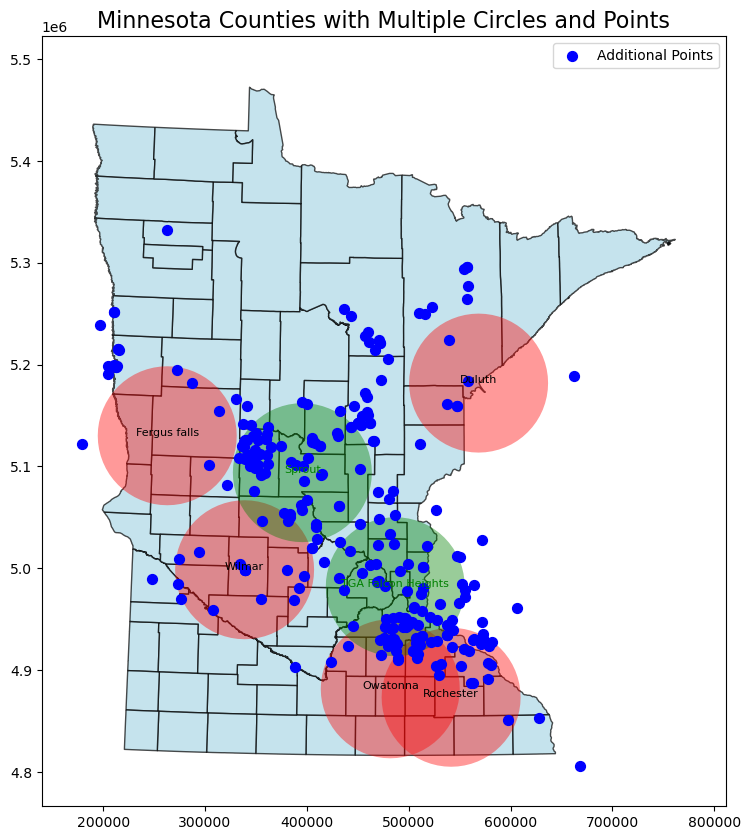

In [173]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(suppliers["Longitude"], suppliers["Latitude"])]
points_gdf = gpd.GeoDataFrame(suppliers, geometry=geometry, crs="EPSG:4326")

# Transform CRS to match the map's CRS
points_gdf = points_gdf.to_crs(counties.crs)

# Plotting the map with added points
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7)  # Plot counties
circles.plot(ax=ax, color='red', alpha=0.4, label='Points')  # Plot original circles
circles_current.plot(ax=ax, color='green', alpha=0.4, label='Current Points')  # Plot current circles
points_gdf.plot(ax=ax, color='blue', markersize=50, label='Additional Points')  # Plot DataFrame points

# Annotate the additional points
# for idx, row in points_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='center', color='blue')

# Annotate the points
for point in points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center')

# Annotate the current points
for point in current_points:
    center = Point(point["coords"])
    center_transformed = gpd.GeoSeries([center], crs="EPSG:4326").to_crs(counties.crs).iloc[0]
    ax.text(center_transformed.x, center_transformed.y, point["name"], fontsize=8, ha='center', color='green')

# Adjust map bounds
minx, miny, maxx, maxy = counties.total_bounds  # Get bounds of counties
ax.set_xlim(minx - 50000, maxx + 50000)  # Add padding around the map
ax.set_ylim(miny - 50000, maxy + 50000)

# Add title and legend
ax.set_title("Minnesota Counties with Multiple Circles and Points", fontsize=16)
ax.legend()

plt.show()

In [176]:
from itertools import combinations

# Create a dictionary to hold the counts for each pair
circle_pair_counts = {}

# Iterate over all pairs of circles
for (circle1, circle2) in combinations(circles.itertuples(), 2):
    # print('hi')
    # Get the geometries of the two circles
    geom1 = circle1.geometry
    geom2 = circle2.geometry
    
    # Calculate the intersection area between the two circles
    intersection = geom1.intersection(geom2)
    
    # Create a GeoDataFrame for the intersection region
    intersection_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=circles.crs)
    
    # Perform spatial join to find points within the intersection region
    points_in_intersection = gpd.sjoin(points_gdf, intersection_gdf, how="inner", predicate="within")
    
    # Count the number of points in the intersection
    num_points = len(points_in_intersection)
    
    # Add the result to the dictionary
    circle_pair_counts[(circle1.name, circle2.name)] = num_points

# Display the results
for pair, count in circle_pair_counts.items():
    if count > 0:
        print(f"Number of points between circles {pair}: {count}")


Number of points between circles ('Owatonna', 'Rochester'): 17
